In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import random
import torch
import torch.backends.cudnn as cudnn

os.chdir('Resources/')

import warnings
warnings.filterwarnings("ignore")

In [2]:
def power(b, p, m):
    b %= m
    if p == 0:
        return 1
    j = power(b, p // 2, m)
    j = (j * j) % m
    if p % 2 == 1:
        j = (j * b) % m
    return j

def mod_inv(a, m):
    origin_m = m
    y, x = 0, 1
    if m == 1:
        return 0
    while a > 1:
        q = a // m
        t = m
        m = a % m
        a = t
        t = y
        y = x - q * y
        x = t
    if x < 0:
        x += origin_m
    return x

def encode_signed(m, p):
    return m % (p - 1)

def decode_signed(m_encoded, p):
    return m_encoded if m_encoded <= (p - 1) // 2 else m_encoded - (p - 1)

def encrypt_additive(m, h, g, p, y=7):
    m_enc = encode_signed(m, p)
    c1 = power(g, y, p)
    s = power(h, y, p)
    c2 = (power(g, m_enc, p) * s) % p
    return c1, c2

def decrypt_additive(ciphertext, x, p, g):
    c1, c2 = ciphertext
    s = power(c1, x, p)
    s_inv = mod_inv(s, p)
    m_encoded = (c2 * s_inv) % p
    for m in range(p - 1):
        if power(g, m, p) == m_encoded:
            return decode_signed(m, p)
    return None

In [3]:
def reset_seeds(seed=42):
    import os
    import random
    import numpy as np
    import tensorflow as tf
    import torch
    import torch.backends.cudnn as cudnn

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

def preprocess_dataset(path, seed=42):
    reset_seeds()
    df = pd.read_csv(path)
    X = df[['Store', 'Dept', 'IsHoliday', 'Year', 'Month', 'Week']].values
    y = df['Weekly_Sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    rf_model = RandomForestRegressor(n_estimators=71, random_state=seed)
    rf_model.fit(X_train, y_train)
    X_train_aug = np.hstack((X_train, rf_model.predict(X_train).reshape(-1, 1)))
    X_test_aug = np.hstack((X_test, rf_model.predict(X_test).reshape(-1, 1)))
    return X_train_aug, X_test_aug, y_train, y_test

def build_mlp(input_dim):
    reset_seeds()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

def train_local(X_train, X_test, y_train, y_test):
    reset_seeds()
    model = build_mlp(X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    return model, r2_score(y_test, y_pred)

def get_gradients_and_flatten(model, X_train, y_train):
    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    X_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        predictions = model(X_tensor, training=True)
        loss = mse_loss_fn(y_tensor, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    flat_grads = []
    for g in gradients:
        flat = tf.reshape(g, [-1]).numpy()
        flat_grads.extend(flat)
    
    return flat_grads

def add_noise_to_gradients(flat_grads, noise_stddev=1.0):
    return [g + tf.random.normal(shape=g.shape, stddev=noise_stddev) for g in flat_grads]

def reconstruct_grads(flat_grads, model):
    reconstructed = []
    idx = 0
    for var in model.trainable_variables:
        shape = var.shape
        size = np.prod(shape)
        chunk = flat_grads[idx:idx + size]
        tensor = tf.convert_to_tensor(np.array(chunk, dtype=np.float32).reshape(shape))
        reconstructed.append(tensor)
        idx += size
    return reconstructed

def apply_gradients(model, avg_grads):
    reset_seeds()
    optimizer = tf.keras.optimizers.Adam()
    optimizer.apply_gradients(zip(avg_grads, model.trainable_variables))

def fine_tune(model, X_train, y_train):
    reset_seeds()
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

In [4]:
p = 1009 # prime number
g = 11 # generator
x = 5 # private key
h = power(g, x, p) # public key (p, g, h)

clients = [f"1_{i}_Client_Data_" for i in range(1, 10)]
rounds = [
    "2010_2", "2010_3", "2010_4", "2010_5", "2010_6", "2010_7", "2010_8", "2010_9", "2010_10", "2010_11", "2010_12",
    "2011_1", "2011_2", "2011_3", "2011_4", "2011_5", "2011_6", "2011_7", "2011_8", "2011_9", "2011_10", "2011_11", "2011_12",
    "2012_1", "2012_2", "2012_3", "2012_4", "2012_5", "2012_6", "2012_7", "2012_8", "2012_9", "2012_10"
    ]

client_models = {}

client_r2_history = {i: [] for i in range(9)}

In [5]:
import time

start_time = time.time()

print("Round 2010_2")
train_data = {}
for idx, client in enumerate(clients):
    path = client + rounds[0] + ".csv"
    X_train, X_test, y_train, y_test = preprocess_dataset(path, seed=42)
    model, r2 = train_local(X_train, X_test, y_train, y_test)
    client_r2_history[idx].append(r2)
    print(f"R² of Client_{idx+1} ({rounds[0]}): {r2:.4f}")
    train_data[idx] = (X_train, X_test, y_train, y_test)
    client_models[idx] = model

scaled_grads_list = []

for i, (idx, model) in enumerate(client_models.items()):
    X_train, _, y_train, _ = train_data[idx]

    grad = get_gradients_and_flatten(model, X_train, y_train)
    noisy_grad = add_noise_to_gradients(grad, noise_stddev=1.0)
    grad = [int(x*1000000) for x in noisy_grad]  

    print(f"Grad {i}:")
    print(grad)

    scaled_grads_list.append(grad)

scaled_grads_splits = [[] for _ in range(8)] 

for grad in scaled_grads_list:
    grad_parts = []
    for i in range(len(scaled_grads_splits)):
        part = [int(str(abs(x)).zfill(16)[2*i:2*i+2]) * (-1 if x < 0 else 1) for x in grad]
        grad_parts.append(part)
    for i, part in enumerate(grad_parts):
        scaled_grads_splits[i].append(part)

decrypted_sums_list = []

for j in range (len(scaled_grads_splits)):
    encrypted_grads = []
    for grad in scaled_grads_splits[j]:
        enc = [encrypt_additive(m, h, g, p) for m in grad]
        encrypted_grads.append(enc)

    from collections import defaultdict

    enc_sums = defaultdict(lambda: (1, 1))
    counts = defaultdict(int)

    for grad in encrypted_grads:
        for i, (c1, c2) in enumerate(grad):
            if i in enc_sums:
                prev_c1, prev_c2 = enc_sums[i]
                enc_sums[i] = ((prev_c1 * c1) % p, (prev_c2 * c2) % p)
            else:
                enc_sums[i] = (c1, c2)
            counts[i] += 1

    decrypted_sums = []
    for i in sorted(enc_sums.keys()):
        avg_cipher = enc_sums[i]
        avg_plain = decrypt_additive(avg_cipher, x, p, g)
        decrypted_sums.append(avg_plain)

    decrypted_sums_list.append(decrypted_sums)

grad_sums = []

for i in range(len(decrypted_sums_list[0])):
    carry = 0
    result_parts = []

    sign = 0
    for j in range(len(scaled_grads_splits)):
        part = decrypted_sums_list[j][i]
        if part != 0:
            sign = -1 if part < 0 else 1
            break
    if sign == 0:
        sign = 1

    for j in reversed(range(len(scaled_grads_splits))):
        val = abs(decrypted_sums_list[j][i]) + carry
        val_str = str(val).zfill(2)

        if len(val_str) > 2:
            carry = int(val_str[:-2])
            part = val_str[-2:]
        else:
            carry = 0
            part = val_str

        result_parts.insert(0, part)

    final_number = int(''.join(result_parts)) * sign
    grad_sums.append(final_number/1000000)

print('Sum of Gradients: ', grad_sums)

grads_avg = [val / len(clients) for val in grad_sums]

print('Average of Gradients: ', grads_avg)

end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")

Round 2010_2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
R² of Client_1 (2010_2): 0.9452
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R² of Client_2 (2010_2): 0.9315
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000240D1908FE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
R² of Client_3 (2010_2): 0.8635
3/3 ━━━━━━━━━

In [6]:
import time

start_time = time.time()

for round_id in rounds[1:]:
    print(f"\nRound ({round_id})")
    new_train_data = {}
    new_client_models = {}

    for idx, client in enumerate(clients):
        path = client + round_id + ".csv"
        X_train, X_test, y_train, y_test = preprocess_dataset(path, seed=42)

        model = build_mlp(X_train.shape[1])
        model(X_train[:1])
        avg_grads_tensor = reconstruct_grads(grads_avg, model)
        apply_gradients(model, avg_grads_tensor)

        fine_tune(model, X_train, y_train)
        r2 = r2_score(y_test, model.predict(X_test))
        client_r2_history[idx].append(r2)
        print(f"R² of Client_{idx+1} ({round_id}): {r2:.4f}")

        new_train_data[idx] = (X_train, X_test, y_train, y_test)
        new_client_models[idx] = model

    scaled_grads_list = []

    for i, (idx, model) in enumerate(client_models.items()):
        X_train, _, y_train, _ = new_train_data[idx]

        grad = get_gradients_and_flatten(model, X_train, y_train)
        noisy_grad = add_noise_to_gradients(grad, noise_stddev=1.0)
        grad = [int(x*1000000) for x in noisy_grad]  

        # print(f"Grad {i}:")
        # print(grad)

        scaled_grads_list.append(grad)

    scaled_grads_splits = [[] for _ in range(8)] 

    for grad in scaled_grads_list:
        grad_parts = []
        for i in range(len(scaled_grads_splits)):
            part = [int(str(abs(x)).zfill(16)[2*i:2*i+2]) * (-1 if x < 0 else 1) for x in grad]
            grad_parts.append(part)
        for i, part in enumerate(grad_parts):
            scaled_grads_splits[i].append(part)

    decrypted_sums_list = []    

    for j in range (len(scaled_grads_splits)):
        encrypted_grads = []
        for grad in scaled_grads_splits[j]:
            enc = [encrypt_additive(m, h, g, p) for m in grad]
            encrypted_grads.append(enc)

        from collections import defaultdict

        enc_sums = defaultdict(lambda: (1, 1))
        counts = defaultdict(int)

        for grad in encrypted_grads:
            for i, (c1, c2) in enumerate(grad):
                if i in enc_sums:
                    prev_c1, prev_c2 = enc_sums[i]
                    enc_sums[i] = ((prev_c1 * c1) % p, (prev_c2 * c2) % p)
                else:
                    enc_sums[i] = (c1, c2)
                counts[i] += 1

        decrypted_sums = []
        for i in sorted(enc_sums.keys()):
            avg_cipher = enc_sums[i]
            avg_plain = decrypt_additive(avg_cipher, x, p, g)
            decrypted_sums.append(avg_plain)

        decrypted_sums_list.append(decrypted_sums)

    grad_sums = []

    for i in range(len(decrypted_sums_list[0])):
        carry = 0
        result_parts = []

        sign = 0
        for j in range(len(scaled_grads_splits)):
            part = decrypted_sums_list[j][i]
            if part != 0:
                sign = -1 if part < 0 else 1
                break
        if sign == 0:
            sign = 1

        for j in reversed(range(len(scaled_grads_splits))):
            val = abs(decrypted_sums_list[j][i]) + carry
            val_str = str(val).zfill(2)

            if len(val_str) > 2:
                carry = int(val_str[:-2])
                part = val_str[-2:]
            else:
                carry = 0
                part = val_str

            result_parts.insert(0, part)

        final_number = int(''.join(result_parts)) * sign
        grad_sums.append(final_number/1000000)

    # print('Average Gradients: ', grad_sums)

    grads_avg = [val / len(clients) for val in grad_sums]
    # print('Average of Gradients: ', grads_avg)

    client_models = new_client_models
    train_data = new_train_data

end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")


Round (2010_3)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R² of Client_1 (2010_3): 0.9268
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
R² of Client_2 (2010_3): 0.9249
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
R² of Client_3 (2010_3): 0.9756
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
R² of Client_4 (2010_3): 0.9716
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
R² of Client_5 (2010_3): 0.9534
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
R² of Client_6 (2010_3): 0.9036
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
R² of Client_7 (2010_3): 0.9525
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² of Client_8 (2010_3): 0.8882
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² of Client_9 (2010_3): 0.9473

Round (2010_4)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
R² of Client_1 (2010_4): 0.9493
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
R² of Client_2 (2010_4): 0.8868
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
R² of Client_3 (2010_4): 0.9588
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² of Client_4 (2010_4): 0.9344
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
R² of Client_5 (2010

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for client_id, r2_list in client_r2_history.items():
    for round_idx, r2 in enumerate(r2_list):
        data.append({
            "Client": f"Client {client_id + 1}",
            "Round": rounds[round_idx],
            "R² Score": r2
        })

df_r2 = pd.DataFrame(data)
df_r2.to_csv("2_9_Client_r2_History.csv", index=False)

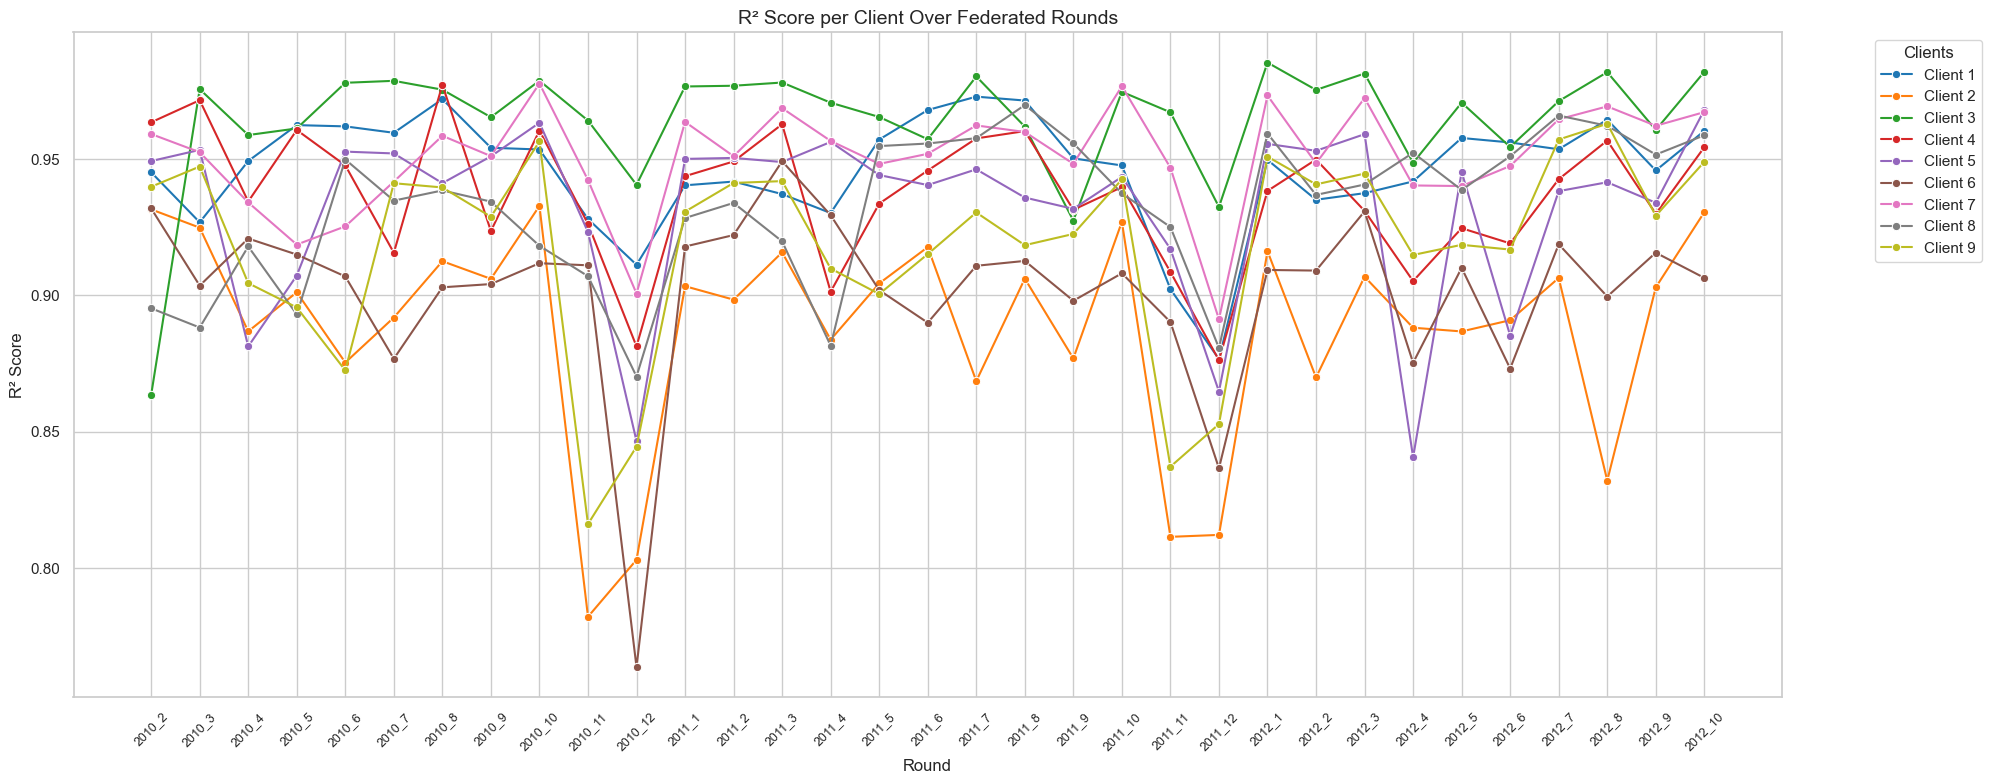

In [8]:
df_r2 = pd.DataFrame(data)
df_r2.to_csv("2_9_Client_r2_History.csv", index=False)

plt.figure(figsize=(20, 8))
sns.set(style="whitegrid")

sns.lineplot(data=df_r2, x="Round", y="R² Score", hue="Client", marker="o", palette="tab10")

plt.title("R² Score per Client Over Federated Rounds", fontsize=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.legend(title="Clients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()